# Image classification with CNN

In [1]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from PIL import Image
from pathlib import Path
import random
from PIL import ImageFilter
import tqdm

random.seed(42)
%matplotlib inline

/userhome/cs2/cahu/anaconda3/envs/apai-img/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

In [2]:
# Device diagnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck',
]
IDX_TO_CLASS = {i: c for i, c in enumerate(CLASSES)}

def get_idx(fname):
    if "(" not in fname:
        return 0
    return int(fname.split("(")[1].split(")")[0]) - 1

def get_image(fname):
    return Image.open(fname)

display(CLASSES)
display(IDX_TO_CLASS)

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
# Training images and labels
DATA_SOURCE = "REAL"
train_path = Path(f"../data/cifake/train/{DATA_SOURCE}")
test_path = Path(f"../data/cifake/test/REAL")
train_images = [get_image(train_path / fname) for fname in os.listdir(train_path)]
train_labels = [get_idx(fname) for fname in os.listdir(train_path)]

train_images[0], train_labels[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32>, 5)

In [5]:
# Testing images and labels
test_images = [get_image(test_path / fname) for fname in os.listdir(test_path)]
test_labels = [get_idx(fname) for fname in os.listdir(test_path)]

test_images[0], test_labels[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32>, 0)

In [6]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

# Self-define Gaussian blur function for data augmentation    
class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [7]:
# Define data augmentation for training and testing images
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.CenterCrop(size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [8]:
# Dataloader
train_dataset = ImageDataset(train_images, train_labels, train_transforms)
test_dataset = ImageDataset(test_images, test_labels, test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=1024, num_workers=os.cpu_count())

In [9]:
example = next(iter(train_dataloader))
example[0].shape

torch.Size([1024, 3, 32, 32])

### Model

In [10]:
# CNN architecture
class ImageClassifier(nn.Module):
    ''' Models a simple CNN image classifier'''
	
    def __init__(self, input_shape, hidden_units, output_shape):
        ''' initialize the network '''
        super(ImageClassifier, self).__init__()
	    # 3 convolutional blocks and 1 feed-forward layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(num_features=hidden_units)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units, 
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(num_features=hidden_units)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units, 
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(num_features=hidden_units)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        return self.classifier(self.conv3(self.conv2(self.conv1(x))))

model = ImageClassifier(input_shape=3, hidden_units=32, output_shape=len(CLASSES))
print(model)

ImageClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_feat

In [11]:
summary(model, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 32, 16, 16]           --
│    └─BatchNorm2d: 2-4                  [1, 32, 16, 16]           64
├─Sequential: 1-2                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 32, 16, 16]           9,248
│    └─ReLU: 2-6                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-7                    [1, 32, 8, 8]             --
│    └─BatchNorm2d: 2-8                  [1, 32, 8, 8]             64
├─Sequential: 1-3                        [1, 32, 4, 4]             --
│    └─Conv2d: 2-9                       [1, 32, 8, 8]             9,248
│    └─R

### Training

In [12]:
# Define training loop
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        # Send data to the device
        X, y = X.to(device), y.to(device)

        # Forward pass + calculate loss + back propagation + optimize step
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_class = torch.argmax(y_pred, axis=1)
        train_acc += (y_class == y).sum().item() / len(y)

    # Calculate metrics
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_class = torch.argmax(y_pred, axis=1)
            test_acc += (y_class == y).sum().item() / len(y_class)
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, output_dir):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "model_state_dict": []}
    with open(f"{output_dir}/result.txt", "w") as f:
        for epoch in range(epochs):
            train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
            test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
            results["model_state_dict"].append(model.state_dict())

        # Write the result
        best_epoch = np.argmax(results["test_acc"]) + 1
        best_train_loss, best_train_acc = results["train_loss"][best_epoch], results["train_acc"][best_epoch]
        best_test_loss, best_test_acc = results["test_loss"][best_epoch], results["test_acc"][best_epoch]
        f.write(
            "Best result:\n"
            f"Epoch: {best_epoch} | "
            f"train_loss: {best_train_loss:.4f} | "
            f"train_acc: {best_train_acc:.4f} | "
            f"test_loss: {best_test_loss:.4f} | "
            f"test_acc: {best_test_acc:.4f}"
        )
        torch.save(model.state_dict(), f"{output_dir}/checkpoint_{best_epoch}.pth")
        plt.plot([x for x in results["train_loss"]], label="Train loss")
        plt.plot([x for x in results["test_loss"]], label="Test loss")
        plt.legend()
        plt.savefig(f"{output_dir}/loss_plot.png")

    return results

/userhome/cs2/cahu/anaconda3/envs/apai-img/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1 | train_loss: 1.9537 | train_acc: 0.2807 | test_loss: 1.7542 | test_acc: 0.3550
Epoch: 2 | train_loss: 1.7686 | train_acc: 0.3555 | test_loss: 1.6159 | test_acc: 0.4140
Epoch: 3 | train_loss: 1.6696 | train_acc: 0.3992 | test_loss: 1.5070 | test_acc: 0.4557
Epoch: 4 | train_loss: 1.6055 | train_acc: 0.4211 | test_loss: 1.4482 | test_acc: 0.4837
Epoch: 5 | train_loss: 1.5628 | train_acc: 0.4397 | test_loss: 1.4261 | test_acc: 0.4917
Epoch: 6 | train_loss: 1.5182 | train_acc: 0.4583 | test_loss: 1.3871 | test_acc: 0.5080
Epoch: 7 | train_loss: 1.4800 | train_acc: 0.4710 | test_loss: 1.3499 | test_acc: 0.5214
Epoch: 8 | train_loss: 1.4609 | train_acc: 0.4776 | test_loss: 1.3241 | test_acc: 0.5276
Epoch: 9 | train_loss: 1.4255 | train_acc: 0.4963 | test_loss: 1.3075 | test_acc: 0.5328
Epoch: 10 | train_loss: 1.4169 | train_acc: 0.4944 | test_loss: 1.2828 | test_acc: 0.5435
Epoch: 11 | train_loss: 1.3868 | train_acc: 0.5058 | test_loss: 1.2599 | test_acc: 0.5527
Epoch: 12 | train_l

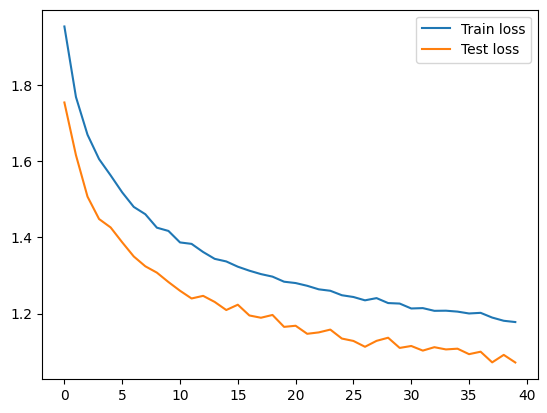

In [13]:
# Training
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
NUM_EPOCHS = 40

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

timestamp = datetime.now().strftime("%y%m%d_%H%M")
output_dir = f"../results/CNN/result_{DATA_SOURCE}_{timestamp}"
os.mkdir(output_dir)
model_results = train(
    model=model, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn, 
    epochs=NUM_EPOCHS,
    output_dir=output_dir
)